# Импорт

In [16]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline
from datetime import datetime, timedelta


# Загружаем специальный удобный инструмент для разделения датасета:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
from sklearn.preprocessing import PolynomialFeatures

# Настройки для более комфортного отображения таблиц
pd.set_option('max_colwidth', 120)
pd.set_option('display.width', 500)
pd.set_option('display.max_rows', 40)
pd.set_option('display.max_columns', 50)


# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

In [17]:
# всегда фиксируйте RANDOM_SEED, чтобы ваши эксперименты были воспроизводимы!
RANDOM_SEED = 42

In [18]:
# зафиксируем версию пакетов, чтобы эксперименты были воспроизводимы:
!pip freeze > requirements.txt

In [19]:
def creatre_columns_NAN(data, list_columns):
    """На вход подаётся список колонок и ДФ, для которых создаются новые колонки с нулями и единицами,
    где 1 - в месте пропуска"""
    data_Nan = pd.DataFrame()
    for i in list_columns:
        data_Nan[i+'_is_NAN'] = pd.isna(data[i]).astype('uint8')
    return data_Nan

In [20]:
def IQR_for_column(column):
    """Функция возвращает квартили, выводит границы для выбросов, согласно IQR и 
    считает сколько выбросов (в том числе в %)"""
    perc25 = data[column].quantile(0.25)
    perc75 = data[column].quantile(0.75)
    IQR = perc75 - perc25
    min_out = perc25 - 1.5*IQR
    max_out = perc75 + 1.5*IQR
    anomaly = len(data[data[column] > max_out]) + \
        len(data[data[column] < min_out])
    print(
        '25-й перцентиль: {} |'.format(perc25),
        '75-й перцентиль: {} |'.format(perc75),
        "IQR: {} | ".format(IQR),
        "Границы выбросов: [{}, {}].".format(min_out, max_out))
    print("Выбросов, согласно IQR: {} | {:2.2%}".format(
        anomaly, anomaly/len(data)))

# DATA

In [21]:
df_train = pd.read_csv('main_task.csv')
df_test = pd.read_csv('kaggle_task.csv')
sample_submission = pd.read_csv('sample_submission.csv')

In [22]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Restaurant_id      40000 non-null  object 
 1   City               40000 non-null  object 
 2   Cuisine Style      30717 non-null  object 
 3   Ranking            40000 non-null  float64
 4   Rating             40000 non-null  float64
 5   Price Range        26114 non-null  object 
 6   Number of Reviews  37457 non-null  float64
 7   Reviews            40000 non-null  object 
 8   URL_TA             40000 non-null  object 
 9   ID_TA              40000 non-null  object 
dtypes: float64(3), object(7)
memory usage: 3.1+ MB


In [23]:
df_train.head(5)

,Restaurant_id,City,Cuisine Style,Ranking,Rating,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA
0,id_5569,Paris,"['European', 'French', 'International']",5570.0,3.5,$$ - $$$,194.0,"[['Good food at your doorstep', 'A good hotel restaurant'], ['12/31/2017', '11/20/2017']]",/Restaurant_Review-g187147-d1912643-Reviews-R_Yves-Paris_Ile_de_France.html,d1912643
1,id_1535,Stockholm,NaN,1537.0,4.0,NaN,10.0,"[['Unique cuisine', 'Delicious Nepalese food'], ['07/06/2017', '06/19/2016']]",/Restaurant_Review-g189852-d7992032-Reviews-Buddha_Nepal-Stockholm.html,d7992032
2,id_352,London,"['Japanese', 'Sushi', 'Asian', 'Grill', 'Vegetarian Friendly', 'Vegan Options', 'Gluten Free Options']",353.0,4.5,$$$$,688.0,"[['Catch up with friends', 'Not exceptional'], ['01/08/2018', '01/06/2018']]",/Restaurant_Review-g186338-d8632781-Reviews-ROKA_Mayfair-London_England.html,d8632781
3,id_3456,Berlin,NaN,3458.0,5.0,NaN,3.0,"[[], []]",/Restaurant_Review-g187323-d1358776-Reviews-Esplanade-Berlin.html,d1358776
4,id_615,Munich,"['German', 'Central European', 'Vegetarian Friendly']",621.0,4.0,$$ - $$$,84.0,"[['Best place to try a Bavarian food', 'Nice building but improvements need to be...'], ['11/18/2017', '02/19/2017']]",/Restaurant_Review-g187309-d6864963-Reviews-Augustiner_Schutzen_Garten-Munich_Upper_Bavaria_Bavaria.html,d6864963


In [24]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Restaurant_id      10000 non-null  object 
 1   City               10000 non-null  object 
 2   Cuisine Style      7693 non-null   object 
 3   Ranking            10000 non-null  float64
 4   Price Range        6525 non-null   object 
 5   Number of Reviews  9343 non-null   float64
 6   Reviews            9998 non-null   object 
 7   URL_TA             10000 non-null  object 
 8   ID_TA              10000 non-null  object 
dtypes: float64(2), object(7)
memory usage: 703.2+ KB


In [25]:
df_test.head(5)

,Restaurant_id,City,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA
0,id_0,Paris,"['Bar', 'Pub']",12963.0,$$ - $$$,4.0,"[[], []]",/Restaurant_Review-g187147-d10746918-Reviews-Le_Perchoir-Paris_Ile_de_France.html,d10746918
1,id_1,Helsinki,"['European', 'Scandinavian', 'Gluten Free Options', 'Vegetarian Friendly', 'Vegan Options']",106.0,$$ - $$$,97.0,"[['Very good reviews!', 'Fine dining in Hakaniemi'], ['12/05/2017', '10/29/2017']]",/Restaurant_Review-g189934-d6674944-Reviews-Ravintola_Kolmon3n-Helsinki_Uusimaa.html,d6674944
2,id_2,Edinburgh,['Vegetarian Friendly'],810.0,$$ - $$$,28.0,"[['Better than the Links', 'Ivy Black'], ['12/28/2017', '12/06/2017']]",/Restaurant_Review-g186525-d13129638-Reviews-Black_Ivy-Edinburgh_Scotland.html,d13129638
3,id_3,London,"['Italian', 'Mediterranean', 'European', 'Vegetarian Friendly', 'Gluten Free Options']",1669.0,$$$$,202.0,"[['Most exquisite', 'Delicious and authentic'], ['12/06/2017', '11/22/2017']]",/Restaurant_Review-g186338-d680417-Reviews-Quirinale-London_England.html,d680417
4,id_4,Bratislava,"['Italian', 'Mediterranean', 'European', 'Seafood', 'Vegetarian Friendly', 'Gluten Free Options']",37.0,$$$$,162.0,"[['Always the best in bratislava', 'Very good but pricey'], ['02/08/2018', '01/24/2018']]",/Restaurant_Review-g274924-d1112354-Reviews-Massimo_Ristorante-Bratislava_Bratislava_Region.html,d1112354


In [26]:
sample_submission.info()
sample_submission.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Restaurant_id  10000 non-null  object 
 1   Rating         10000 non-null  float64
dtypes: float64(1), object(1)
memory usage: 156.4+ KB


,Restaurant_id,Rating
0,id_0,2.0
1,id_1,2.5
2,id_2,4.0
3,id_3,1.0
4,id_4,4.0


In [27]:
sample_submission.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Restaurant_id  10000 non-null  object 
 1   Rating         10000 non-null  float64
dtypes: float64(1), object(1)
memory usage: 156.4+ KB


In [28]:
# ВАЖНО! дря корректной обработки признаков объединяем трейн и тест в один датасет
df_train['sample'] = 1 # помечаем где у нас трейн
df_test['sample'] = 0 # помечаем где у нас тест
df_test['Rating'] = 0 # в тесте у нас нет значения Rating, мы его должны предсказать, по этому пока просто заполняем нулями

data = df_test.append(df_train, sort=False).reset_index(drop=True) # объединяем

In [29]:
data.info()
display(data.sample(3))
print("Размер общего датасета: {}".format(data.shape))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Restaurant_id      50000 non-null  object 
 1   City               50000 non-null  object 
 2   Cuisine Style      38410 non-null  object 
 3   Ranking            50000 non-null  float64
 4   Price Range        32639 non-null  object 
 5   Number of Reviews  46800 non-null  float64
 6   Reviews            49998 non-null  object 
 7   URL_TA             50000 non-null  object 
 8   ID_TA              50000 non-null  object 
 9   sample             50000 non-null  int64  
 10  Rating             50000 non-null  float64
dtypes: float64(3), int64(1), object(7)
memory usage: 4.2+ MB


,Restaurant_id,City,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,sample,Rating
21831,id_3429,Barcelona,"['Japanese', 'Sushi']",3430.0,$$ - $$$,15.0,"[[], []]",/Restaurant_Review-g187497-d11962459-Reviews-Restaurante_Tokio-Barcelona_Catalonia.html,d11962459,1,4.0
30176,id_1669,Dublin,['Irish'],1673.0,$,6.0,"[['Pleasantly surprised', 'Excellent'], ['09/23/2017', '09/18/2017']]",/Restaurant_Review-g186605-d11779663-Reviews-Barbers_Bar-Dublin_County_Dublin.html,d11779663,1,3.5
19195,id_6367,London,"['Asian', 'Japanese', 'Vegan Options', 'Vegetarian Friendly']",6376.0,$$ - $$$,19.0,"[['Very tasty', 'Same standards across the country'], ['10/28/2017', '08/11/2017']]",/Restaurant_Review-g186338-d10860065-Reviews-Wagamama-London_England.html,d10860065,1,4.0


Размер общего датасета: (50000, 11)


Подробнее по признакам:
* City: Город 
* Cuisine Style: Кухня
* Ranking: Ранг ресторана относительно других ресторанов в этом городе
* Price Range: Цены в ресторане в 3 категориях
* Number of Reviews: Количество отзывов
* Reviews: 2 последних отзыва и даты этих отзывов
* URL_TA: страница ресторана на 'www.tripadvisor.com' 
* ID_TA: ID ресторана в TripAdvisor
* Rating: Рейтинг ресторана

In [30]:
data.sample(5)

,Restaurant_id,City,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,sample,Rating
22051,id_171,Paris,"['French', 'American', 'Vegetarian Friendly', 'Vegan Options']",172.0,$$ - $$$,312.0,"[['Fantastic', 'What a nice surprise!!!'], ['12/31/2017', '12/10/2017']]",/Restaurant_Review-g187147-d8419890-Reviews-Baagaa-Paris_Ile_de_France.html,d8419890,1,4.5
27523,id_3500,Prague,['Japanese'],3508.0,NaN,2.0,"[[], []]",/Restaurant_Review-g274707-d7123474-Reviews-Koke_Iwa_Chatsitsu_Tearoom_Mechova_Skala-Prague_Bohemia.html,d7123474,1,4.0
12771,id_507,Vienna,"['Italian', 'Pizza', 'European', 'Vegetarian Friendly', 'Vegan Options']",508.0,$$ - $$$,78.0,"[['The place to be...definitely.', 'Pizza e allora? YES PIZZA and SO WHAT?'], ['09/07/2017', '05/05/2017']]",/Restaurant_Review-g190454-d3668066-Reviews-Minante-Vienna.html,d3668066,1,4.5
47933,id_5387,Berlin,NaN,5389.0,NaN,2.0,"[['Good Dalmatian restaurant'], ['02/06/2017']]",/Restaurant_Review-g187323-d5826307-Reviews-Dalmacija_Restaurant-Berlin.html,d5826307,1,3.5
37697,id_1715,Budapest,['Chinese'],1716.0,NaN,3.0,"[[], []]",/Restaurant_Review-g274887-d10289832-Reviews-Orient_Chinese_Restaurant-Budapest_Central_Hungary.html,d10289832,1,4.0


In [31]:
data.Reviews[1]

"[['Very good reviews!', 'Fine dining in Hakaniemi'], ['12/05/2017', '10/29/2017']]"

Как видим, большинство признаков у нас требует очистки и предварительной обработки.

# Cleaning and Prepping Data
Обычно данные содержат в себе кучу мусора, который необходимо почистить, для того чтобы привести их в приемлемый формат. Чистка данных — это необходимый этап решения почти любой реальной задачи.   


## 1. Обработка NAN 
У наличия пропусков могут быть разные причины, но пропуски нужно либо заполнить, либо исключить из набора полностью. Но с пропусками нужно быть внимательным, **даже отсутствие информации может быть важным признаком!**   
По этому перед обработкой NAN лучше вынести информацию о наличии пропуска как отдельный признак 

Дубликатов найдено: 0
Пропусков найдено: 32153


<AxesSubplot:>

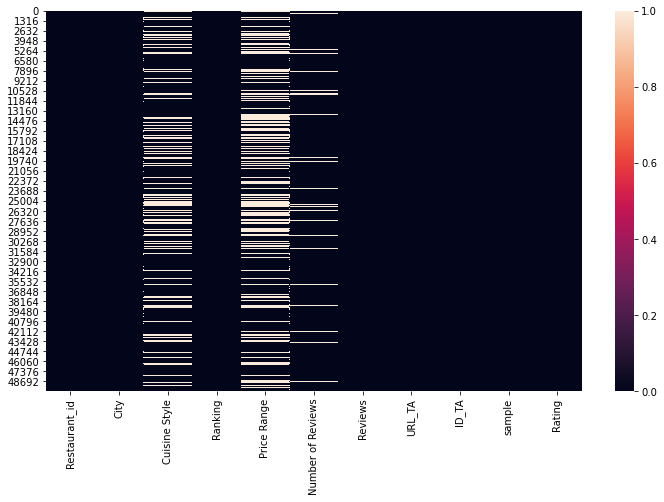

In [32]:
# Проверяем, где есть пропуски и дубликаты
print("Дубликатов найдено:", data.duplicated(keep=False).sum())
print("Пропусков найдено:", data.isnull().sum().sum())

# "Матрица" с пропусками для наглядной оценки
plt.subplots(figsize=(12, 7))
sns.heatmap(data.isnull())

In [33]:
# Cоздаём список колонок, для которых сделаем другие колонки, отмечающие места пропусков
list_columns_with_Nan = ['Number of Reviews',
                         'Cuisine Style', 'Price Range', 'Reviews']

# Сохраним их в отдельный ДФ, который присоединим к data перед моделированием
columns_NAN = creatre_columns_NAN(data, list_columns_with_Nan)
columns_NAN

,Number of Reviews_is_NAN,Cuisine Style_is_NAN,Price Range_is_NAN,Reviews_is_NAN
0,0,0,0,0
1,0,0,0,0
2,0,0,0,0
3,0,0,0,0
4,0,0,0,0
...,...,...,...,...
49995,0,0,0,0
49996,0,0,0,0
49997,0,0,1,0
49998,0,0,0,0


In [34]:
data.drop(['Restaurant_id', 'URL_TA'], axis = 1, inplace=True) 

## ID_TA

In [35]:
# Удалим символ "d" из признака ID_TA
data['ID_TA'] = data['ID_TA'].apply(lambda x:x[1:])

# City

Text(0, 0.5, 'Город')

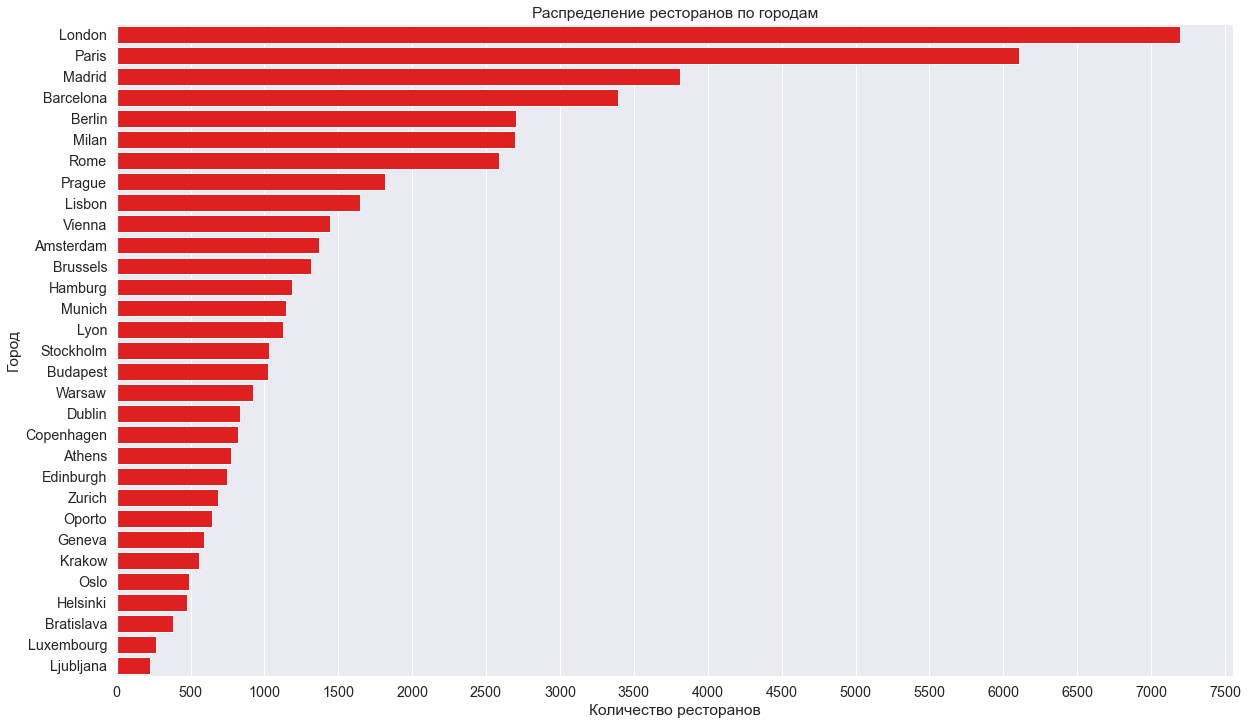

In [36]:
# Посмотрим на распределение ресторанов по городам
sns.set(font_scale=1.3)
plt.subplots(figsize=(20, 12))
plt.xticks(ticks=range(0, 7501, 500))
plt.title('Распределение ресторанов по городам')
sns.countplot(y="City",
              data=data,
              order=data.City.value_counts().index,
              color='red')
plt.xlabel('Количество ресторанов')
plt.ylabel('Город')

In [37]:
# Создадим таблицы по городам со средними и медианными значениями для дальнейшей замены пропусков
data_city_mean = data.groupby('City').mean().round()
#data_city_median = data.groupby('City').median()
data_city_max = data.groupby('City').max(1)
data_city_mean

,Ranking,Number of Reviews,sample,Rating
City,,,,
Amsterdam,1592.0,149.0,1.0,3.0
Athens,880.0,94.0,1.0,3.0
Barcelona,3879.0,136.0,1.0,3.0
Berlin,3255.0,64.0,1.0,3.0
Bratislava,462.0,52.0,1.0,3.0
Brussels,1542.0,93.0,1.0,3.0
Budapest,1219.0,159.0,1.0,3.0
Copenhagen,982.0,95.0,1.0,3.0
Dublin,972.0,154.0,1.0,3.0


# Cuisine Style

In [38]:
data['Cuisine Style'].sample(5)

33425    ['European', 'Dutch', 'Vegetarian Friendly']
32832                         ['African', 'European']
40201               ['French', 'Belgian', 'European']
18412                                             NaN
18624                           ['Pizza', 'European']
Name: Cuisine Style, dtype: object

Значения в колонке представляют собой строки, в которых в квадратный скобках через запятую представлены виды кухонь в ресторане. Удалим скобки и кавычки, которые кое-где встречаются. Разобъем строку по запятым в список и посчитаем его длину - это и будет количество кухонь в ресторане. Если нет данных, то предположим, что в данном ресторане представлен только один вид

In [39]:
data['Cuisine Style'].fillna('[]', inplace=True)
data['Cuisine Style'] = data['Cuisine Style'].apply(
    lambda x: str(x).replace('[', '').replace(']', '').replace("'", '').replace(' ', '').replace('"', ''))
data['Cuisine Style'] = data['Cuisine Style'].apply(lambda x: x.split(','))
data['Number_of_kitchen'] = data['Cuisine Style'].apply(lambda x: len(x))

# Посмотрим на IQR-статистику
IQR_for_column('Number_of_kitchen')

25-й перцентиль: 1.0 | 75-й перцентиль: 4.0 | IQR: 3.0 |  Границы выбросов: [-3.5, 8.5].
Выбросов, согласно IQR: 126 | 0.25%


<AxesSubplot:title={'center':'Распределение количества представленных кухонь'}, xlabel='Количество кухонь', ylabel='Число ресторанов'>

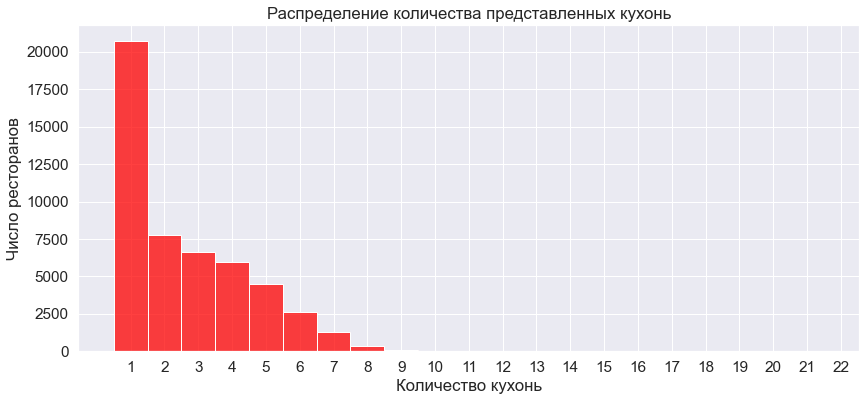

In [40]:
sns.set(font_scale=1.4)
plt.figure(figsize=(14, 6))
plt.xticks(ticks=range(1, 25, 1))
plt.title('Распределение количества представленных кухонь')
plt.xlabel('Количество кухонь')
plt.ylabel('Число ресторанов')
sns.histplot(data['Number_of_kitchen'], discrete=True, color='red')

<AxesSubplot:title={'center':'Распределение количества представленных кухонь > 8'}, xlabel='Количество кухонь', ylabel='Чисто ресторанов'>

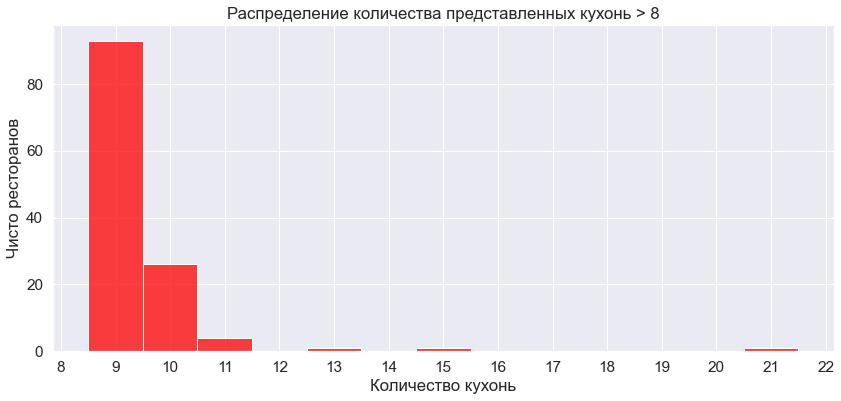

In [41]:
# Посмотрим внимательнее на количество ресторанов, в которых представленных кухонь больше восьми
sns.set(font_scale=1.4)
plt.figure(figsize=(14, 6))
plt.xticks(ticks=range(1, 25, 1))
plt.title('Распределение количества представленных кухонь > 8')
plt.xlabel('Количество кухонь')
plt.ylabel('Чисто ресторанов')
sns.histplot(data[data['Number_of_kitchen']>=9]['Number_of_kitchen'], discrete=True, color='red')

#### Возьмем следующий признак "Price Range".

In [42]:
data['Price Range'].value_counts()

$$ - $$$    23041
$            7816
$$$$         1782
Name: Price Range, dtype: int64

По описанию 'Price Range' это - Цены в ресторане.  
Их можно поставить по возрастанию (значит это не категориальный признак). А это значит, что их можно заменить последовательными числами, например 1,2,3  
*Попробуйте сделать обработку этого признака уже самостоятельно!*

In [43]:
# Ваша обработка 'Price Range'

# Price Range

In [44]:
print('Всего у {} ресторанов ({:.2%}) не указана ценовая категория'.format(
    data['Price Range'].isnull().sum(), 
    data['Price Range'].isnull().sum()/len(data)))

Всего у 17361 ресторанов (34.72%) не указана ценовая категория


In [45]:
data['Price Range'].value_counts()

$$ - $$$    23041
$            7816
$$$$         1782
Name: Price Range, dtype: int64

Заменим значения на 1, 2 или 3 соотвественно. Посмотрим на средние цены по городам

In [46]:
data['Price Range'] = data['Price Range'].apply(
    lambda x: 1 if x == '$' else 2 if x == '$$ - $$$' else 3 if x == '$$$$' else x)

Text(0, 0.5, 'Ценовая категория')

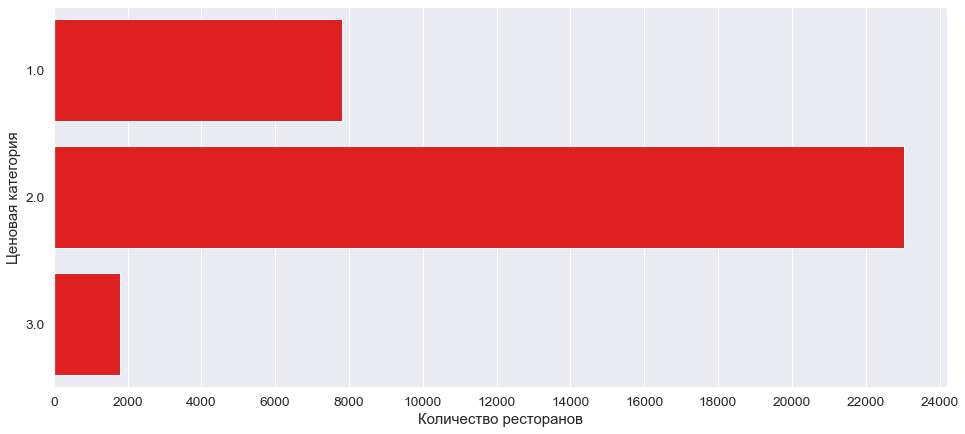

In [47]:
# Посмотрим на распределение ресторанов по цене
sns.set(font_scale=1.25)
plt.figure(figsize=(16, 7))
plt.xticks(ticks=range(0, 30000, 2000))
sns.countplot(y=data['Price Range'], color='red', orient='v')
plt.xlabel('Количество ресторанов')
plt.ylabel('Ценовая категория')

# Ranking

Text(0, 0.5, 'Количество ресторанов')

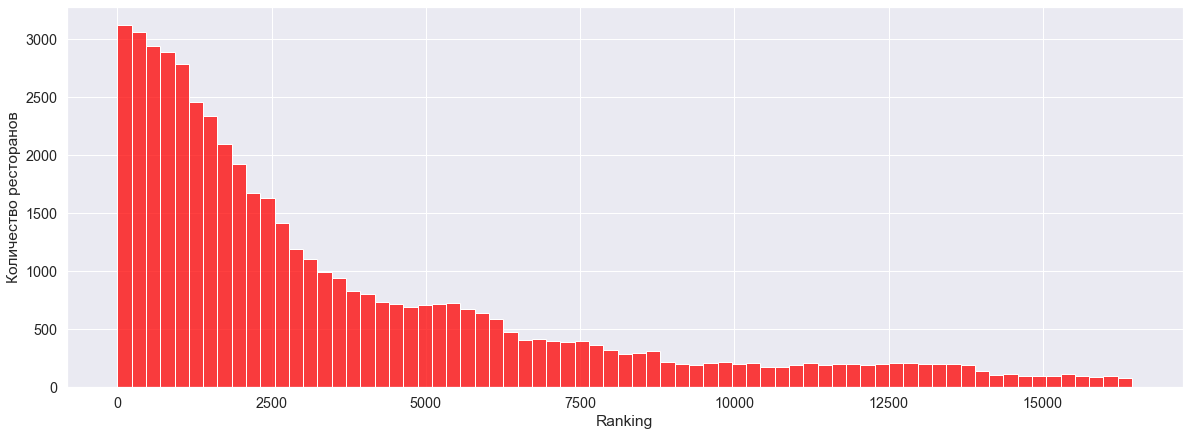

In [48]:
# Посмотрим распредение ресторанов по рангу
sns.set(font_scale=1.3)
plt.subplots(figsize=(20, 7))
sns.histplot(data['Ranking'], color='red')
plt.ylabel('Количество ресторанов')

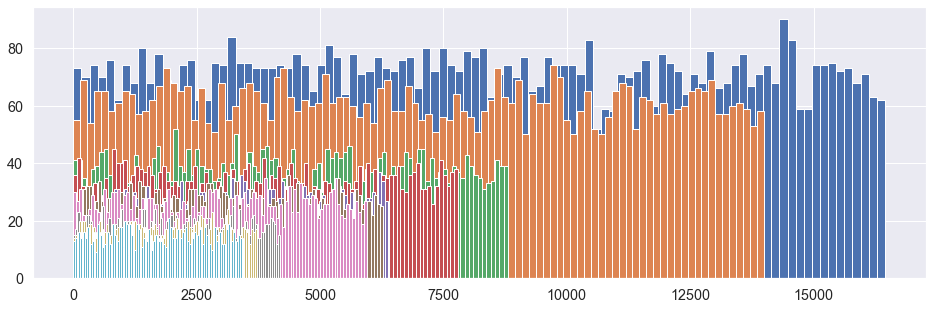

In [49]:
# Посмотрим на данные по Ranking топ 10-ти городов
for x in (data['City'].value_counts())[0:10].index:
    data['Ranking'][data['City'] == x].hist(bins=100, figsize=(16,5))

В больших городах больше ресторанов, значит Ranking у некоторых может быть очень высокий. Нужно нормировать значения по городам, чтобы при обучении модели не было ошибок.

In [50]:
# Создаём колонку с нормированным по городам рангом ресторанов
data['Ranking_NORM'] = data[['City', 'Ranking']].apply(
    lambda x: x[1]/data_city_max.Ranking[x[0]], axis=1)

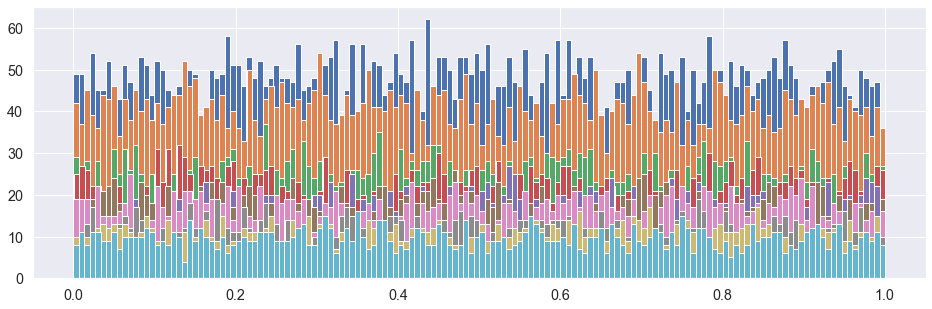

In [51]:
# Данные по нормированному Ranking топ 10-ти городов
for x in (df_train['City'].value_counts())[0:10].index:
    data['Ranking_NORM'][data['City'] == x].hist(bins=150, figsize=(16, 5))

# Number of Reviews

In [52]:
print('Количество пропусков в колонке Number of Reviews: {}'.format(
    data['Number of Reviews'].isnull().sum()))

Количество пропусков в колонке Number of Reviews: 3200


25-й перцентиль: 10.0 | 75-й перцентиль: 124.0 | IQR: 114.0 |  Границы выбросов: [-161.0, 295.0].
Выбросов, согласно IQR: 5039 | 10.08%


Text(0, 0.5, 'Количество ресторанов')

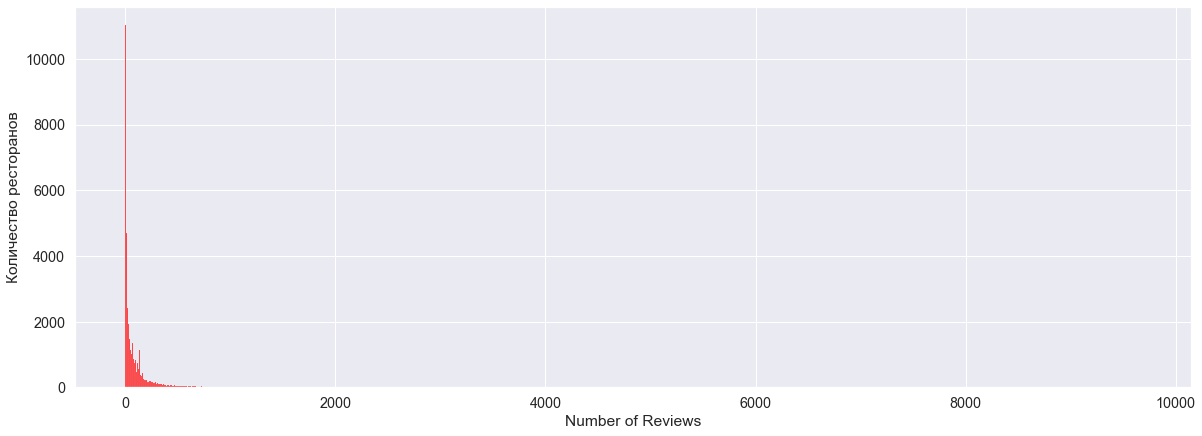

In [53]:
# Заменим на среднее количество отзывов в городе
data['Number of Reviews'] = data[['City', 'Number of Reviews']].apply(
    lambda x: data_city_mean['Number of Reviews'].to_dict()[x[0]] if pd.isna(x[1]) else x[1], axis=1)

IQR_for_column('Number of Reviews')

# Посмотрим на распределение по количеству отзывов
sns.set(font_scale=1.3)
plt.subplots(figsize=(20, 7))
sns.histplot(data['Number of Reviews'], color='red')
plt.ylabel('Количество ресторанов')

Очень много низких значений. Более 10% выбросов согластно IQR. Логарифмируем данное значение, чтобы сгладить распределение и тем самым уменьшить количество аномальных значений

25-й перцентиль: 2.3978952727983707 | 75-й перцентиль: 4.8283137373023015 | IQR: 2.430418464503931 |  Границы выбросов: [-1.2477324239575256, 8.473941434058197].
Выбросов, согласно IQR: 18 | 0.04%


Text(0, 0.5, 'Количество ресторанов')

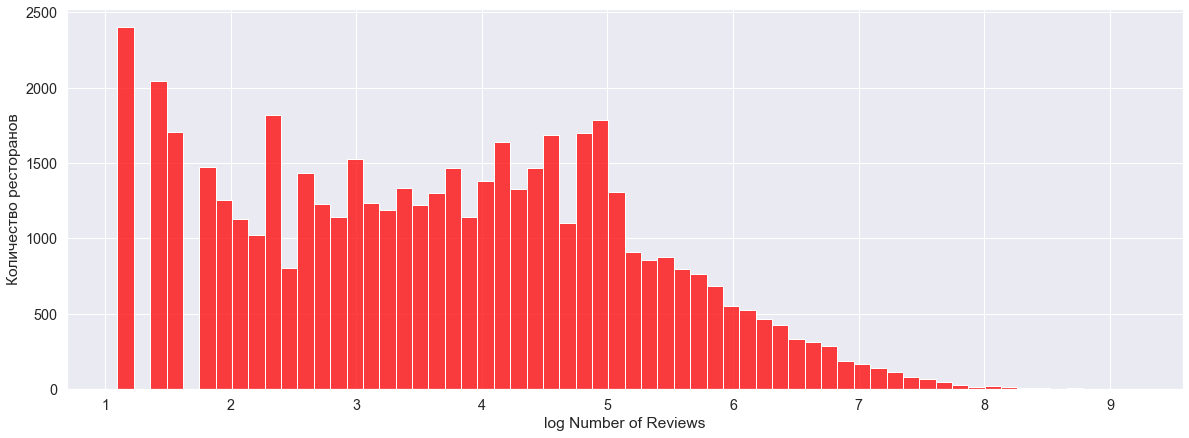

In [54]:
data['log Number of Reviews'] = np.log(data['Number of Reviews'] + 1)
IQR_for_column('log Number of Reviews')
sns.set(font_scale=1.3)
plt.subplots(figsize=(20, 7))
sns.histplot(data['log Number of Reviews'], color='red')
plt.ylabel('Количество ресторанов')

Распределение заметно улучшилось, немного нормализовалось. Осталось всего 18 выбросов согласно IQR

# EDA 
[Exploratory Data Analysis](https://ru.wikipedia.org/wiki/Разведочный_анализ_данных) - Анализ данных
На этом этапе мы строим графики, ищем закономерности, аномалии, выбросы или связи между признаками.
В общем цель этого этапа понять, что эти данные могут нам дать и как признаки могут быть взаимосвязаны между собой.
Понимание изначальных признаков позволит сгенерировать новые, более сильные и, тем самым, сделать нашу модель лучше.


### Посмотрим распределение признака

<AxesSubplot:>

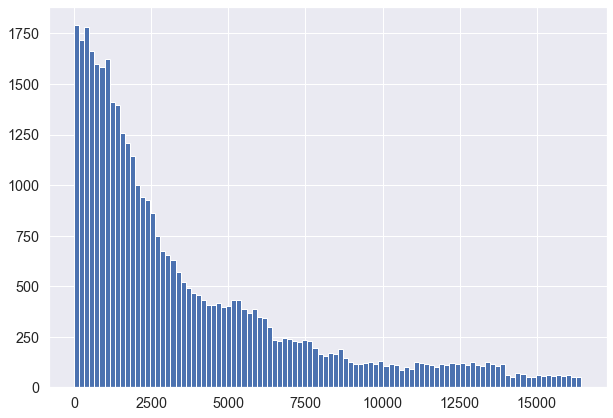

In [55]:
plt.rcParams['figure.figsize'] = (10,7)
df_train['Ranking'].hist(bins=100)

У нас много ресторанов, которые не дотягивают и до 2500 места в своем городе, а что там по городам?

<AxesSubplot:>

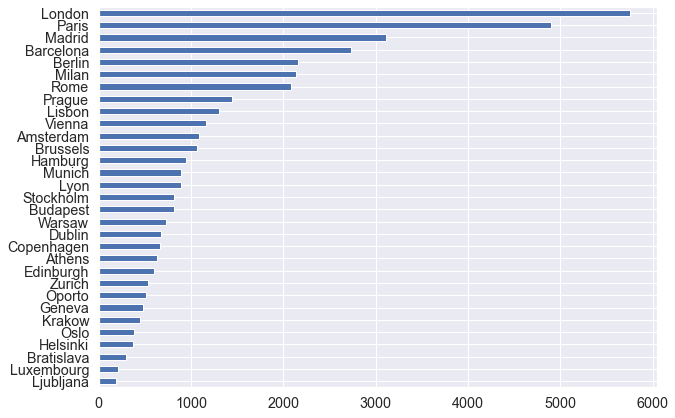

In [56]:
df_train['City'].value_counts(ascending=True).plot(kind='barh')

Посмотрим, как изменится распределение в большом городе:

<AxesSubplot:>

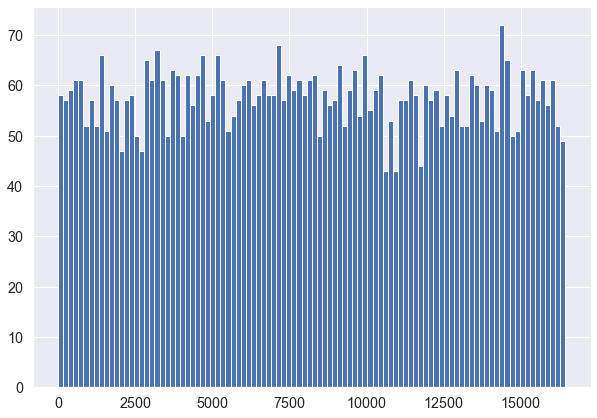

In [57]:
df_train['Ranking'][df_train['City'] =='London'].hist(bins=100)

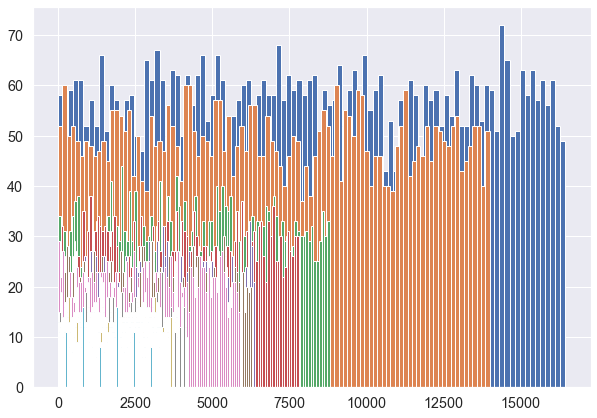

In [58]:
# посмотрим на топ 10 городов
for x in (df_train['City'].value_counts())[0:10].index:
    df_train['Ranking'][df_train['City'] == x].hist(bins=100)
plt.show()

Получается, что Ranking имеет нормальное распределение, просто в больших городах больше ресторанов, из-за мы этого имеем смещение.

>Подумайте как из этого можно сделать признак для вашей модели. Я покажу вам пример, как визуализация помогает находить взаимосвязи. А далее действуйте без подсказок =) 


### Посмотрим распределение целевой переменной

<AxesSubplot:>

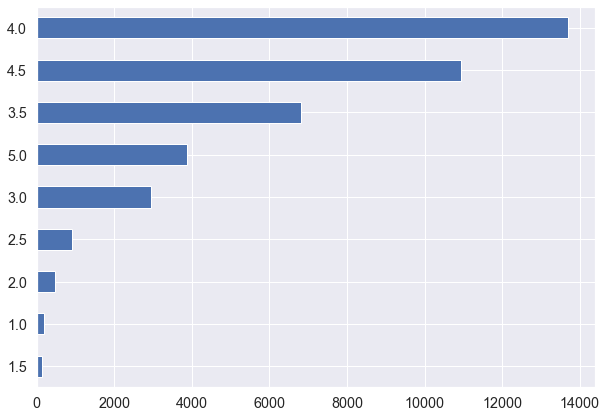

In [59]:
df_train['Rating'].value_counts(ascending=True).plot(kind='barh')

### Посмотрим распределение целевой переменной относительно признака

<AxesSubplot:>

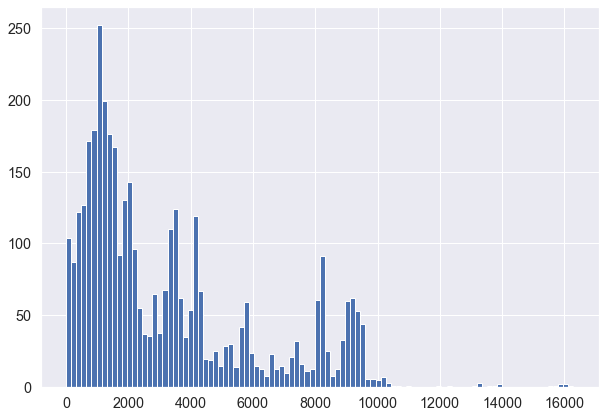

In [60]:
df_train['Ranking'][df_train['Rating'] == 5].hist(bins=100)

<AxesSubplot:>

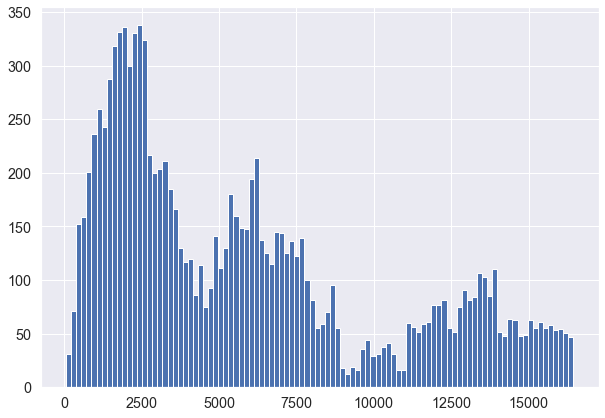

In [61]:
df_train['Ranking'][df_train['Rating'] < 4].hist(bins=100)

## Корреляция признаков
На этом графике уже сейчас вы сможете заметить, как признаки связаны между собой и с целевой переменной.

<AxesSubplot:>

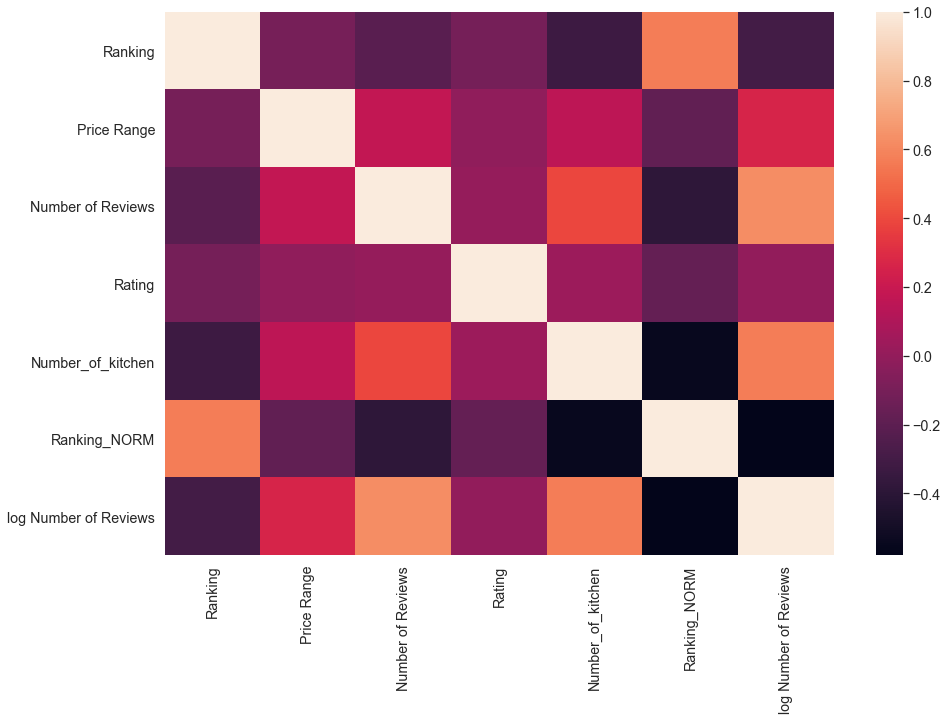

In [62]:
plt.rcParams['figure.figsize'] = (15,10)
sns.heatmap(data.drop(['sample'], axis=1).corr(),)

Вообще благодаря визуализации в этом датасете можно узнать много интересных фактов, например:
* где больше Пицерий в Мадриде или Лондоне?
* в каком городе кухня ресторанов более разнообразна?

придумайте свои вопрос и найдите на него ответ в данных)

# Data Preprocessing
Теперь, для удобства и воспроизводимости кода, завернем всю обработку в одну большую функцию.

In [63]:
# на всякий случай, заново подгружаем данные
df_train = pd.read_csv('main_task.csv')
df_test = pd.read_csv('kaggle_task.csv')
df_train['sample'] = 1 # помечаем где у нас трейн
df_test['sample'] = 0 # помечаем где у нас тест
df_test['Rating'] = 0 # в тесте у нас нет значения Rating, мы его должны предсказать, по этому пока просто заполняем нулями

data = df_test.append(df_train, sort=False).reset_index(drop=True) # объединяем
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Restaurant_id      50000 non-null  object 
 1   City               50000 non-null  object 
 2   Cuisine Style      38410 non-null  object 
 3   Ranking            50000 non-null  float64
 4   Price Range        32639 non-null  object 
 5   Number of Reviews  46800 non-null  float64
 6   Reviews            49998 non-null  object 
 7   URL_TA             50000 non-null  object 
 8   ID_TA              50000 non-null  object 
 9   sample             50000 non-null  int64  
 10  Rating             50000 non-null  float64
dtypes: float64(3), int64(1), object(7)
memory usage: 4.2+ MB


In [64]:
def preproc_data(df_input):
    '''includes several functions to pre-process the predictor data.'''
    
    df_output = df_input.copy()
    
    # ################### 1. Предобработка ############################################################## 
    # убираем не нужные для модели признаки
    df_output.drop(['Restaurant_id','ID_TA',], axis = 1, inplace=True)
    
    
    # ################### 2. NAN ############################################################## 
    # Далее заполняем пропуски, вы можете попробовать заполнением средним или средним по городу и тд...
    df_output['Number of Reviews'].fillna(0, inplace=True)
    # тут ваш код по обработке NAN
    # ....
    
    
    # ################### 3. Encoding ############################################################## 
    # для One-Hot Encoding в pandas есть готовая функция - get_dummies. Особенно радует параметр dummy_na
    df_output = pd.get_dummies(df_output, columns=[ 'City',], dummy_na=True)
    # тут ваш код не Encoding фитчей
    # ....
    
    
    # ################### 4. Feature Engineering ####################################################
    # тут ваш код не генерацию новых фитчей
    # ....
    
    
    # ################### 5. Clean #################################################### 
    # убираем признаки которые еще не успели обработать, 
    # модель на признаках с dtypes "object" обучаться не будет, просто выберим их и удалим
    object_columns = [s for s in df_output.columns if df_output[s].dtypes == 'object']
    df_output.drop(object_columns, axis = 1, inplace=True)
    
    return df_output

>По хорошему, можно было бы перевести эту большую функцию в класс и разбить на подфункции (согласно ООП). 

#### Запускаем и проверяем что получилось

In [65]:
df_preproc = preproc_data(data)
df_preproc.sample(10)

,Ranking,Number of Reviews,sample,Rating,City_Amsterdam,City_Athens,City_Barcelona,City_Berlin,City_Bratislava,City_Brussels,City_Budapest,City_Copenhagen,City_Dublin,City_Edinburgh,City_Geneva,City_Hamburg,City_Helsinki,City_Krakow,City_Lisbon,City_Ljubljana,City_London,City_Luxembourg,City_Lyon,City_Madrid,City_Milan,City_Munich,City_Oporto,City_Oslo,City_Paris,City_Prague,City_Rome,City_Stockholm,City_Vienna,City_Warsaw,City_Zurich,City_nan
24164,2945.0,25.0,1,3.5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
41835,2997.0,175.0,1,3.5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
1109,3870.0,2.0,0,0.0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
31410,3036.0,27.0,1,3.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
20493,629.0,46.0,1,4.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
15755,3309.0,4.0,1,4.5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9555,2268.0,47.0,0,0.0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5179,12039.0,6.0,0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4215,1553.0,58.0,0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
38410,1081.0,137.0,1,3.5,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [66]:
df_preproc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 36 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Ranking            50000 non-null  float64
 1   Number of Reviews  50000 non-null  float64
 2   sample             50000 non-null  int64  
 3   Rating             50000 non-null  float64
 4   City_Amsterdam     50000 non-null  uint8  
 5   City_Athens        50000 non-null  uint8  
 6   City_Barcelona     50000 non-null  uint8  
 7   City_Berlin        50000 non-null  uint8  
 8   City_Bratislava    50000 non-null  uint8  
 9   City_Brussels      50000 non-null  uint8  
 10  City_Budapest      50000 non-null  uint8  
 11  City_Copenhagen    50000 non-null  uint8  
 12  City_Dublin        50000 non-null  uint8  
 13  City_Edinburgh     50000 non-null  uint8  
 14  City_Geneva        50000 non-null  uint8  
 15  City_Hamburg       50000 non-null  uint8  
 16  City_Helsinki      500

In [67]:
# Теперь выделим тестовую часть
train_data = df_preproc.query('sample == 1').drop(['sample'], axis=1)
test_data = df_preproc.query('sample == 0').drop(['sample'], axis=1)

y = train_data.Rating.values            # наш таргет
X = train_data.drop(['Rating'], axis=1)

**Перед тем как отправлять наши данные на обучение, разделим данные на еще один тест и трейн, для валидации. 
Это поможет нам проверить, как хорошо наша модель работает, до отправки submissiona на kaggle.**

In [68]:
# Воспользуемся специальной функцие train_test_split для разбивки тестовых данных
# выделим 20% данных на валидацию (параметр test_size)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

In [69]:
# проверяем
test_data.shape, train_data.shape, X.shape, X_train.shape, X_test.shape

((10000, 35), (40000, 35), (40000, 34), (32000, 34), (8000, 34))

# Model 
Сам ML

In [70]:
# Импортируем необходимые библиотеки:
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели
from sklearn import metrics # инструменты для оценки точности модели

In [71]:
# Создаём модель (НАСТРОЙКИ НЕ ТРОГАЕМ)
model = RandomForestRegressor(n_estimators=100, verbose=1, n_jobs=-1, random_state=RANDOM_SEED)

In [72]:
# Обучаем модель на тестовом наборе данных
model.fit(X_train, y_train)

# Используем обученную модель для предсказания рейтинга ресторанов в тестовой выборке.
# Предсказанные значения записываем в переменную y_pred
y_pred = model.predict(X_test)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  38 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.5s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.0s
[Parallel(n_jobs=6)]: Done 100 out of 100 | elapsed:    0.0s finished


In [73]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они в среднем отличаются
# Метрика называется Mean Absolute Error (MAE) и показывает среднее отклонение предсказанных значений от фактических.
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))

MAE: 0.21240125


<AxesSubplot:>

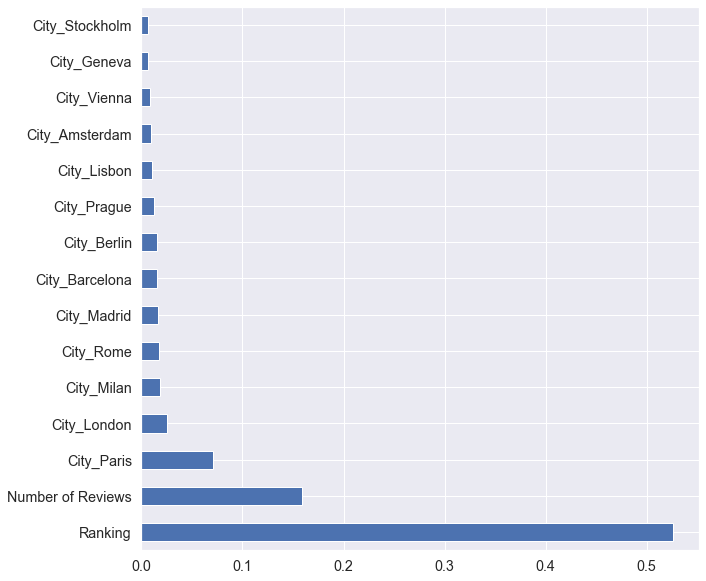

In [74]:
# в RandomForestRegressor есть возможность вывести самые важные признаки для модели
plt.rcParams['figure.figsize'] = (10,10)
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(15).plot(kind='barh')

# Submission

In [75]:
test_data.sample(10)

,Ranking,Number of Reviews,Rating,City_Amsterdam,City_Athens,City_Barcelona,City_Berlin,City_Bratislava,City_Brussels,City_Budapest,City_Copenhagen,City_Dublin,City_Edinburgh,City_Geneva,City_Hamburg,City_Helsinki,City_Krakow,City_Lisbon,City_Ljubljana,City_London,City_Luxembourg,City_Lyon,City_Madrid,City_Milan,City_Munich,City_Oporto,City_Oslo,City_Paris,City_Prague,City_Rome,City_Stockholm,City_Vienna,City_Warsaw,City_Zurich,City_nan
7430,2820.0,7.0,0.0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1181,2257.0,4.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
6683,3460.0,14.0,0.0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5629,5499.0,59.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
7353,2421.0,0.0,0.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
431,102.0,604.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
7388,1400.0,2.0,0.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5166,1206.0,93.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
4569,1085.0,43.0,0.0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4662,5642.0,66.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [76]:
test_data = test_data.drop(['Rating'], axis=1)

In [77]:
sample_submission

,Restaurant_id,Rating
0,id_0,2.0
1,id_1,2.5
2,id_2,4.0
3,id_3,1.0
4,id_4,4.0
...,...,...
9995,id_9995,3.0
9996,id_9996,1.5
9997,id_9997,4.5
9998,id_9998,1.0


In [78]:
predict_submission = model.predict(test_data)

[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.0s
[Parallel(n_jobs=6)]: Done 100 out of 100 | elapsed:    0.0s finished


In [79]:
predict_submission

array([3.005, 4.295, 4.56 , ..., 3.   , 4.5  , 4.32 ])

In [80]:
sample_submission['Rating'] = predict_submission
sample_submission.to_csv('submission.csv', index=False)
sample_submission.head(10)

,Restaurant_id,Rating
0,id_0,3.005
1,id_1,4.295
2,id_2,4.560
3,id_3,4.155
4,id_4,4.485
5,id_5,4.580
6,id_6,1.475
7,id_7,3.220
8,id_8,4.100
9,id_9,4.750
